/home/david/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


cuda
Seed: 123
Upstream Model File Path: ./upstream_seq2seq/models/transformer_cnn_4heads_1701990699.9536803.pt
Num attention heads: 8


/home/david/anaconda3/lib/python3.9/site-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


2246929


Within epoch loss (training) 0.24145:  60%|██████    | 3/5 [00:03<00:02,  1.17s/it]


KeyboardInterrupt: 

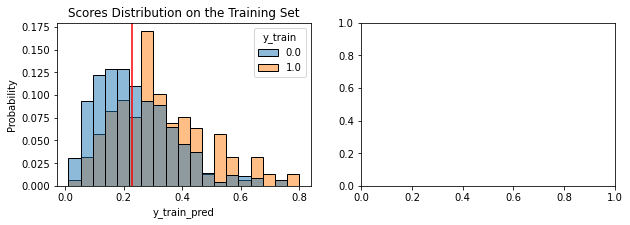

In [1]:
import os
os.chdir('/home/david/Desktop/projects/thesis/')

# import sys
# sys.path.append('/home/david/Desktop/projects/thesis/')

import numpy as np
import pickle 

from combined_downstream_upstream.utils.LoadModels import *
from combined_downstream_upstream.executors.train_combined_model import trainer


# upstream model params
# ---------------
upstream_params = {
    'input_dimension': 12,
    'output_dimension': 12,              
    'hidden_dimmension':  128,           # d_model (int) – the number of expected features in the input (required)???,
    'attention_heads': 8,               # number of attention heads, if None then d_model//64,
    'encoder_number_of_layers': 8,
    'dropout': 0.4,
    'clip': 1,
    'positional_encodings': False,
    'device':'cuda'
}
best_rocauc_and_pr_auc = {
    'seed':[],
    'validation-roc-auc':[],
    'validation-pr-auc':[],
    'test-roc-auc':[],
    'test-pr-auc':[],
}

seed = 123
np.random.seed(123)
seeds = np.random.randint(0,1000, 50)

for seed_ in seeds:
    print('Seed:', seed)
    upstream_model   = load_upstream_model(upstream_params, folder_path = './upstream_seq2seq/models/', model_name = 'transformer_cnn_4heads')
    downstream_model = load_downstream_model(dropout=0.5,scale=1,num_inputs=12, weights_path='./downstream_classification/models/AF-V9/model_val_rocauc.pt')



    config = {
            # general
            'seed':seed_,
            'metadata_file_path': './downstream_classification/data/combined_data/metadata_only_existant_readings_09042023_sample_of_1000.csv',
            # 'metadata_file_path': './downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv',
            'data_folder_path': './downstream_classification/data/individual-signals/',
            'targets': ['AF'],
            'leads': ['LI', 'LII', 'LIII', 'aVF', 'aVL', 'aVR','V1','V2','V3','V4','V5','V6'],

            # training
            'batch_size': 128,
            'n_epochs': 10, # catastrophic forgetting
            'weight_decay': 0.3,
            'lr': 0.0005,
            'eval_metric':'rocauc',
            'patience':3,
            'clip':1,
            'loss_function_weight':None,

            # Experiment settings
            'upstream_model':upstream_model,
            'downstream_model':downstream_model,
            'impute_only_missing':False,
            'continue_training_upstream_model':True,
            'model_saving_path':'./combined_downstream_upstream/models/AF-V5-different-seeds',

            'reconstruction_loss_weight':0.5,

            # test
            'check_on_test':True,
            'plot':True,
            'plot_saving_path':'/home/david/Desktop/projects/thesis/combined_downstream_upstream/plots/V10/',

            }

    best_rocauc_and_pr_auc_seed = trainer(**config)
    
    best_rocauc_and_pr_auc['seed'].append(seed_)
    best_rocauc_and_pr_auc['validation-roc-auc'].append(best_rocauc_and_pr_auc_seed['validation-roc-auc'])
    best_rocauc_and_pr_auc['validation-pr-auc'].append(best_rocauc_and_pr_auc_seed['validation-auc-pr'])
    best_rocauc_and_pr_auc['test-roc-auc'].append(best_rocauc_and_pr_auc_seed['test-roc-auc'])
    best_rocauc_and_pr_auc['test-pr-auc'].append(best_rocauc_and_pr_auc_seed['test-auc-pr'])
    
    with open(config['model_saving_path']+'/best_rocauc_and_pr_auc.pkl', 'wb') as f:
        pickle.dump(best_rocauc_and_pr_auc, f)


In [ ]:
import sys
sys.exit(0)

In [ ]:
# import pandas as pd
# metadata = pd.read_csv('./downstream_classification/data/combined_data/metadata_only_existant_readings_09042023.csv', index_col=0)
# metadata_sample = metadata.sample(n=1000).reset_index(drop = True)
# metadata_sample['sample'].value_counts()

train         711
test          145
validation    144
Name: sample, dtype: int64

In [ ]:
import torch
import numpy as np
import torch.nn as nn

X = torch.randn(12,7)
X[2] = 0
X[6] = 0
X
# x1 = torch.from_numpy(x1)
# x2 = torch.from_numpy(x2)
# nn.MSELoss(x1,x2)


tensor([[ 0.4708,  1.0661, -1.1070, -0.0546,  0.2821, -1.0658,  1.6445],
        [ 0.2468,  0.1526,  0.6004, -1.1296, -1.4728,  0.7698, -3.0358],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 1.3445,  0.5311, -1.2310,  0.4879, -1.2281, -1.4141,  1.2972],
        [ 0.7291,  0.7135,  0.1809,  0.2194, -1.0352,  1.1511,  1.5047],
        [ 1.3031, -0.9245,  0.6503,  0.1432,  0.4830, -0.5816, -1.0250],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.8956,  0.0204, -0.3234, -1.7892, -0.6476,  0.2088, -1.2477],
        [ 0.5682, -0.4021,  0.5059, -0.7913, -0.2690,  0.0759, -0.8475],
        [ 1.0397, -0.5426, -1.5914, -0.3543, -1.7055, -1.1548, -1.7783],
        [ 0.2109, -0.0186, -0.0385, -0.6466, -0.6346, -0.2124,  0.7210],
        [-1.7837, -1.8141, -1.2359,  0.2603, -0.1289, -0.0235,  0.5824]])

In [ ]:
mask = X!=0
mask.shape, X[mask].shape
new_mask = mask[:,0]
X[new_mask].shape

torch.Size([10, 7])

In [ ]:
mask.shape

torch.Size([3, 2, 12])

In [ ]:

# Assuming X is your tensor with shape (10, 12, 7)
X = torch.randn(10, 12, 7)

# Assuming mask is your 2D mask with shape (10, 12)
mask = torch.rand(10, 12) > 0.5  # Example mask with random True/False

# Apply the mask to each "sub-tensor" of X
filtered_tensors = torch.from_numpy(np.array([X[i][mask[i]] for i in range(X.shape[0])]))
filtered_tensors

[tensor([[-0.0212, -0.8621,  0.7918,  0.3615, -0.7413,  0.9035,  1.8251],
         [-0.4687,  0.9083, -0.1546,  1.2870,  0.7000, -0.5278,  0.6533],
         [-0.0429, -1.9673,  0.1245,  0.9132,  0.1220,  1.3823, -1.0253],
         [ 0.5102, -0.3961, -0.1939, -1.2770,  1.1359,  0.7756, -0.1593],
         [-1.0129, -0.4736,  0.8479,  0.6473, -0.5666,  0.0731, -0.8311],
         [-0.1012, -1.0160, -0.7194, -0.5386,  1.1907,  1.2755, -0.1819],
         [-1.0142,  1.4965,  2.1490, -0.7290, -1.2205,  2.0168, -0.8545]]),
 tensor([[-1.4296,  0.7687, -0.6362, -1.1581, -0.3854, -1.3251,  1.8590],
         [ 0.6099,  0.7114, -0.9596,  0.8558, -0.5708, -1.3283, -0.0457],
         [-1.4530,  0.1701, -0.1852,  0.3961, -0.5055, -1.2344,  2.8439],
         [ 0.2452,  1.1301,  1.0829,  0.6453,  0.5471,  1.9413,  0.0481],
         [ 0.2683, -1.7192,  0.7792,  0.7972, -0.0839, -1.4357, -1.8529],
         [-1.6621,  0.7724,  2.8930,  0.0496,  0.1912,  1.3508,  0.9493],
         [-0.6937,  0.9131, -1.0013,